# Bring Your Own R Algorithm
_**Create a Docker container for training R algorithms and hosting R models**_

---

---

## Notes

awesome blog post:
<https://aws.amazon.com/de/blogs/machine-learning/train-and-host-scikit-learn-models-in-amazon-sagemaker-by-building-a-scikit-docker-container/>

```bash
aws ec2 describe-regions --output table
aws configure get region ## [[?]]
aws configure set region us-east-1
```

Maybe create notebook with specific role?
```
arn:aws:iam::519784521283:role/umDatascience
```



---

---

## Contents

1. [Background](#Background)
1. [Preparation](#Preparation)
1. [Code](#Code)
  1. [Fit](#Fit)
  1. [Serve](#Serve)
  1. [Dockerfile](#Dockerfile)
  1. [Publish](#Publish)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
1. [Predict](#Predict)
1. [Extensions](#Extensions)

---
## Background

R is a popular open source statistical programming language, with a lengthy history in Data Science and Machine Learning.  The breadth of algorithms available as an R package is impressive, which fuels a growing community of users.  The R kernel can be installed into Amazon SageMaker Notebooks, and Docker containers which use R can be used to take advantage of Amazon SageMaker's flexible training and hosting functionality.  This notebook illustrates a simple use case for creating an R container and then using it to train and host a model.  In order to take advantage of boto, we'll use Python within the notebook, but this could be done 100% in R by invoking command line arguments.

---
## Preparation

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [16]:
bucket = 'um-ds-testbucket'    ## currently, in the same region as the notebook instance
prefix = 'sagemaker/DEMO-r-byo'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

print()
#client = boto3.client('sagemaker')
#print(client.describe_notebook_instance(NotebookInstanceName = "um-inna-testing-v004-access-any-s3"))

arn:aws:iam::519784521283:role/service-role/AmazonSageMaker-ExecutionRole-20180905T101877



Now we'll import the libraries we'll need for the remainder of the notebook.

In [61]:
import time
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

### Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because we'll be creating a new repository in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

---
## Code

For this example, we'll need 3 supporting code files.

### Fit

`mars.R` creates functions to fit and serve our model.  The algorithm we've chosen to use is [Multivariate Adaptive Regression Splines](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines).  This is a suitable example as it's a unique and powerful algorithm, but isn't as broadly used as Amazon SageMaker algorithms, and it isn't available in Python's scikit-learn library.  R's repository of packages is filled with algorithms that share these same criteria. 

_The top of the code is devoted to setup.  Bringing in the libraries we'll need and setting up the file paths as detailed in Amazon SageMaker documentation on bringing your own container._

```
# Bring in library that contains multivariate adaptive regression splines (MARS)
library(mda)

# Bring in library that allows parsing of JSON training parameters
library(jsonlite)

# Bring in library for prediction server
library(plumber)


# Setup parameters
# Container directories
prefix <- '/opt/ml'
input_path <- paste(prefix, 'input/data', sep='/')
output_path <- paste(prefix, 'output', sep='/')
model_path <- paste(prefix, 'model', sep='/')
param_path <- paste(prefix, 'input/config/hyperparameters.json', sep='/')

# Channel holding training data
channel_name = 'train'
training_path <- paste(input_path, channel_name, sep='/')
```

_Next, we define a train function that actually fits the model to the data.  For the most part this is idiomatic R, with a bit of maneuvering up front to take in parameters from a JSON file, and at the end to output a success indicator._

```
# Setup training function
train <- function() {

    # Read in hyperparameters
    training_params <- read_json(param_path)

    target <- training_params$target

    if (!is.null(training_params$degree)) {
        degree <- as.numeric(training_params$degree)}
    else {
        degree <- 2}

    # Bring in data
    training_files = list.files(path=training_path, full.names=TRUE)
    training_data = do.call(rbind, lapply(training_files, read.csv))
    
    # Convert to model matrix
    training_X <- model.matrix(~., training_data[, colnames(training_data) != target])

    # Save factor levels for scoring
    factor_levels <- lapply(training_data[, sapply(training_data, is.factor), drop=FALSE],
                            function(x) {levels(x)})
    
    # Run multivariate adaptive regression splines algorithm
    model <- mars(x=training_X, y=training_data[, target], degree=degree)
    
    # Generate outputs
    mars_model <- model[!(names(model) %in% c('x', 'residuals', 'fitted.values'))]
    attributes(mars_model)$class <- 'mars'
    save(mars_model, factor_levels, file=paste(model_path, 'mars_model.RData', sep='/'))
    print(summary(mars_model))

    write.csv(model$fitted.values, paste(output_path, 'data/fitted_values.csv', sep='/'), row.names=FALSE)
    write('success', file=paste(output_path, 'success', sep='/'))}
```

_Then, we setup the serving function (which is really just a short wrapper around our plumber.R file that we'll discuss [next](#Serve)._

```
# Setup scoring function
serve <- function() {
    app <- plumb(paste(prefix, 'plumber.R', sep='/'))
    app$run(host='0.0.0.0', port=8080)}
```

_Finally, a bit of logic to determine if, based on the options passed when Amazon SageMaker Training or Hosting call this script, we are using the container to train an algorithm or host a model._

```
# Run at start-up
args <- commandArgs()
if (any(grepl('train', args))) {
    train()}
if (any(grepl('serve', args))) {
    serve()}
```

### Serve
`plumber.R` uses the [plumber](https://www.rplumber.io/) package to create a lightweight HTTP server for processing requests in hosting.  Note the specific syntax, and see the plumber help docs for additional detail on more specialized use cases.

Per the Amazon SageMaker documentation, our service needs to accept post requests to ping and invocations.  plumber specifies this with custom comments, followed by functions that take specific arguments.

Here invocations does most of the work, ingesting our trained model, handling the HTTP request body, and producing a CSV output of predictions.

```
# plumber.R


#' Ping to show server is there
#' @get /ping
function() {
    return('')}


#' Parse input and return the prediction from the model
#' @param req The http request sent
#' @post /invocations
function(req) {

    # Setup locations
    prefix <- '/opt/ml'
    model_path <- paste(prefix, 'model', sep='/')

    # Bring in model file and factor levels
    load(paste(model_path, 'mars_model.RData', sep='/'))

    # Read in data
    conn <- textConnection(gsub('\\\\n', '\n', req$postBody))
    data <- read.csv(conn)
    close(conn)

    # Convert input to model matrix
    scoring_X <- model.matrix(~., data, xlev=factor_levels)

    # Return prediction
    return(paste(predict(mars_model, scoring_X, row.names=FALSE), collapse=','))}
```

### Dockerfile

Smaller containers are preferred for Amazon SageMaker as they lead to faster spin up times in training and endpoint creation, so this container is kept minimal.  It simply starts with Ubuntu, installs R, mda, and plumber libraries, then adds `mars.R` and `plumber.R`, and finally runs `mars.R` when the entrypoint is launched.

```Dockerfile
FROM ubuntu:16.04

MAINTAINER Amazon SageMaker Examples <amazon-sagemaker-examples@amazon.com>

RUN apt-get -y update && apt-get install -y --no-install-recommends \
    wget \
    r-base \
    r-base-dev \
    ca-certificates

RUN R -e "install.packages(c('mda', 'plumber'), repos='https://cloud.r-project.org')"

COPY mars.R /opt/ml/mars.R
COPY plumber.R /opt/ml/plumber.R

ENTRYPOINT ["/usr/bin/Rscript", "/opt/ml/mars.R", "--no-save"]
```

### Publish
Now, to publish this container to ECR, we'll run the comands below.

This command will take several minutes to run the first time.

In [4]:
## For training, you want your 
## - Amazon S3 bucket for training data 
##   to be in the same region as your 
## - Amazon SageMaker training job and your 
## - training container.

## For inference, you will need to push your model and your inference container 
## to each Region in which you want to have it available in Amazon SageMaker.

In [20]:
%%sh
## some addtional notes on what happenes in cell below:
algorithm_name=rmars
account=$(aws sts get-caller-identity --query Account --output text)
region=$(aws configure get region)
region=${region:-us-west-2}
fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

aws configure get region

echo $account
echo $region
echo $fullname
aws ecr describe-repositories
#aws ecr create-repository --repository-name "${algorithm_name}"
aws ecr describe-repositories --repository-names "${algorithm_name}"

eu-central-1
519784521283
eu-central-1
519784521283.dkr.ecr.eu-central-1.amazonaws.com/rmars:latest
{
    "repositories": [
        {
            "repositoryArn": "arn:aws:ecr:eu-central-1:519784521283:repository/rmars",
            "registryId": "519784521283",
            "repositoryName": "rmars",
            "repositoryUri": "519784521283.dkr.ecr.eu-central-1.amazonaws.com/rmars",
            "createdAt": 1536148328.0
        }
    ]
}
{
    "repositories": [
        {
            "repositoryArn": "arn:aws:ecr:eu-central-1:519784521283:repository/rmars",
            "registryId": "519784521283",
            "repositoryName": "rmars",
            "repositoryUri": "519784521283.dkr.ecr.eu-central-1.amazonaws.com/rmars",
            "createdAt": 1536148328.0
        }
    ]
}


In [23]:
## set up policy; this might be to permissive:
## Add custom role IAM 
## --> Roles 
## --> AmazonSageMaker-ExecutionRole-20180905T101877 (the role used to create the notebook) 
## --> add inline policy 
## --> JSON:

print("""
{
"Version": "2012-10-17",
"Statement": [
    {
        "Effect": "Allow",
        "Action": [
            "ecr:*",
            "sagemaker:*",
            "ec2:*"
            ],
        "Resource": "*"
    }
]}
""")
## (without the triple quotes)


{
"Version": "2012-10-17",
"Statement": [
    {
        "Effect": "Allow",
        "Action": [
            "ecr:*",
            "sagemaker:*",
            "ec2:*"
            ],
        "Resource": "*"
    }
]}



In [21]:
%%sh

# The name of our algorithm
algorithm_name=rmars

#set -e # stop if anything fails

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded

Step 1/7 : FROM ubuntu:16.04
16.04: Pulling from library/ubuntu
3b37166ec614: Pulling fs layer
ba077e1ddb3a: Pulling fs layer
34c83d2bc656: Pulling fs layer
84b69b6e4743: Pulling fs layer
0f72e97e1f61: Pulling fs layer
84b69b6e4743: Waiting
0f72e97e1f61: Waiting
ba077e1ddb3a: Verifying Checksum
ba077e1ddb3a: Download complete
34c83d2bc656: Verifying Checksum
34c83d2bc656: Download complete
84b69b6e4743: Verifying Checksum
84b69b6e4743: Download complete
0f72e97e1f61: Verifying Checksum
0f72e97e1f61: Download complete
3b37166ec614: Verifying Checksum
3b37166ec614: Download complete
3b37166ec614: Pull complete
ba077e1ddb3a: Pull complete
34c83d2bc656: Pull complete
84b69b6e4743: Pull complete
0f72e97e1f61: Pull complete
Digest: sha256:a218d8dacc99e49cbdc5862d5c6ee105eb40d4e87bec2e4dac37361c30171ce0
Status: Downloaded newer image for ubuntu:16.04
 ---> 52b10959e8aa
Step 2/7 : MAINTAINER Amazon SageMaker Examples <amazon-sagemaker-examples@amazon.com>
 ---> Running in 3d0c

WARNING! Using --password via the CLI is insecure. Use --password-stdin.


In [79]:
%%bash
echo "## show all running containers (on the notebook instance, in this case)"
docker container ls     ## show all running containers (on the notebook instance, in this case)
# docker container ls -a  ## show all containers
echo
echo "## show all image files on local disk"
docker image ls   
echo
echo "## show all registered images in rmars repository"
aws ecr describe-images --repository-name rmars

## show all running containers (on the notebook instance, in this case)
CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES

## show all image files on local disk
REPOSITORY                                              TAG                 IMAGE ID            CREATED             SIZE
519784521283.dkr.ecr.eu-central-1.amazonaws.com/rmars   latest              7ced85d40973        About an hour ago   772MB
rmars                                                   latest              7ced85d40973        About an hour ago   772MB
ubuntu                                                  16.04               52b10959e8aa        13 days ago         115MB

## show all registered images in rmars repository
{
    "imageDetails": [
        {
            "registryId": "519784521283",
            "repositoryName": "rmars",
            "imageDigest": "sha256:8097620d8ca037426bc03ed40d92117b851a236577ecc3c7a7a986fa416335cb",
        

So the container seems to be in the ECR repository... nice!

---
## Data
For this illustrative example, we'll simply use `iris`.  This a classic, but small, dataset used to test supervised learning algorithms.  Typically the goal is to predict one of three flower species based on various measurements of the flowers' attributes.  Further detail can be found [here](https://en.wikipedia.org/wiki/Iris_flower_data_set).

Then let's copy the data to S3.

In [31]:
train_file = 'iris.csv'
boto3.Session().resource('s3').Bucket(bucket).\
Object(os.path.join(prefix, 'train', train_file)).\
upload_file(train_file)

_Note: Although we could, we'll avoid doing any preliminary transformations on the data, instead choosing to do those transformations inside the container.  This is not typically the best practice for model efficiency, but provides some benefits in terms of flexibility._

In [47]:
!aws s3 ls um-ds-testbucket/sagemaker/DEMO-r-byo/train/

2018-09-05 12:14:59       3716 iris.csv


In [55]:
#boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', train_file)).

for object in boto3.Session().resource('s3').Bucket(bucket).objects.all():
    print(object)

s3.ObjectSummary(bucket_name='um-ds-testbucket', key='Lufthansa_Seeheim_More_than_a_Conference_Hotel.jpg')
s3.ObjectSummary(bucket_name='um-ds-testbucket', key='Veolia/')
s3.ObjectSummary(bucket_name='um-ds-testbucket', key='Veolia/Analogwerte66.csv')
s3.ObjectSummary(bucket_name='um-ds-testbucket', key='Veolia/Veolia Daten 2016_08_15.zip')
s3.ObjectSummary(bucket_name='um-ds-testbucket', key='sagemaker/DEMO-r-byo/train/iris.csv')


## Train: Local Testing

File `train_local.sh`:
```
#!/bin/sh

image=$1

mkdir -p test_dir/model
mkdir -p test_dir/output

rm test_dir/model/*
rm test_dir/output/*

docker run -v $(pwd)/test_dir:/opt/ml --rm ${image} train
```

---
## Train

Now, let's setup the information needed to train a Multivariate Adaptive Regression Splines (MARS) model on iris data.  In this case, we'll predict `Sepal.Length` rather than the more typical classification of `Species` to show how factors might be included in a model and limit the case to regression.

First, we'll get our region and account information so that we can point to the ECR container we just created.

In [56]:
region = boto3.Session().region_name
account = boto3.client('sts').get_caller_identity().get('Account')
print(account)

519784521283



- Specify the role to use
- Give the training job a name
- Point the algorithm to the container we created
- Specify training instance resources (in this case our algorithm is only single-threaded so stick to 1 instance)
- Point to the S3 location of our input data and the `train` channel expected by our algorithm
- Point to the S3 location for output
- Provide hyperparamters (keeping it simple)
- Maximum run time

In [63]:
r_job = 'DEMO-r-byo-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Training job", r_job)

r_training_params = {
    "RoleArn": role,
    "TrainingJobName": r_job,
    "AlgorithmSpecification": {
        "TrainingImage": '{}.dkr.ecr.{}.amazonaws.com/rmars:latest'.format(account, region),
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)
    },
    "HyperParameters": {
        "target": "Sepal.Length",
        "degree": "2"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}
#print(r_training_params)
print(json.dumps(r_training_params, indent=2))

Training job DEMO-r-byo-2018-09-05-12-37-22
{
  "RoleArn": "arn:aws:iam::519784521283:role/service-role/AmazonSageMaker-ExecutionRole-20180905T101877",
  "TrainingJobName": "DEMO-r-byo-2018-09-05-12-37-22",
  "AlgorithmSpecification": {
    "TrainingImage": "519784521283.dkr.ecr.eu-central-1.amazonaws.com/rmars:latest",
    "TrainingInputMode": "File"
  },
  "ResourceConfig": {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 10
  },
  "InputDataConfig": [
    {
      "ChannelName": "train",
      "DataSource": {
        "S3DataSource": {
          "S3DataType": "S3Prefix",
          "S3Uri": "s3://um-ds-testbucket/sagemaker/DEMO-r-byo/train",
          "S3DataDistributionType": "FullyReplicated"
        }
      },
      "CompressionType": "None",
      "RecordWrapperType": "None"
    }
  ],
  "OutputDataConfig": {
    "S3OutputPath": "s3://um-ds-testbucket/sagemaker/DEMO-r-byo/output"
  },
  "HyperParameters": {
    "target": "Sepal.Length",
    "degre

Now let's kick off our training job on Amazon SageMaker Training, using the parameters we just created.  Because training is managed (AWS takes care of spinning up and spinning down the hardware), we don't have to wait for our job to finish to continue, but for this case, let's setup a waiter so we can monitor the status of our training.

In [64]:
%%time

sm = boto3.client('sagemaker')
sm.create_training_job(**r_training_params)

status = sm.describe_training_job(TrainingJobName=r_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=r_job)
status = sm.describe_training_job(TrainingJobName=r_job)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=r_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 4min


In [70]:
## trained model now saved in S3:
## <bucket>/sagemaker/DEMO-r-byo/output/DEMO-r-byo-2018-09-05-12-37-22/output/
!aws s3 ls um-ds-testbucket/sagemaker/DEMO-r-byo/output/DEMO-r-byo-2018-09-05-12-37-22/output/

2018-09-05 12:44:58        879 model.tar.gz
2018-09-05 12:44:59       1307 output.tar.gz


---
## Host

Hosting the model we just trained takes three steps in Amazon SageMaker.  First, we define the model we want to host, pointing the service to the model artifact our training job just wrote to S3.

In [74]:
r_hosting_container = {
    'Image': '{}.dkr.ecr.{}.amazonaws.com/rmars:latest'.format(account, region),
    'ModelDataUrl': sm.describe_training_job(TrainingJobName=r_job)['ModelArtifacts']['S3ModelArtifacts']
}
print(json.dumps(r_hosting_container, indent = 2))
print()

create_model_response = sm.create_model(
    ModelName=r_job,
    ExecutionRoleArn=role,
    PrimaryContainer=r_hosting_container)

print(create_model_response['ModelArn'])

{
  "Image": "519784521283.dkr.ecr.eu-central-1.amazonaws.com/rmars:latest",
  "ModelDataUrl": "s3://um-ds-testbucket/sagemaker/DEMO-r-byo/output/DEMO-r-byo-2018-09-05-12-37-22/output/model.tar.gz"
}



ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Cannot create already existing model "arn:aws:sagemaker:eu-central-1:519784521283:model/demo-r-byo-2018-09-05-12-37-22".

In [75]:
print(create_model_response['ModelArn'])

arn:aws:sagemaker:eu-central-1:519784521283:model/demo-r-byo-2018-09-05-12-37-22


Next, let's create an endpoing configuration, passing in the model we just registered.  In this case, we'll only use a few c4.xlarges.

In [80]:
## list registered models:
!aws sagemaker list-models

{
    "Models": [
        {
            "ModelName": "DEMO-r-byo-2018-09-05-12-37-22",
            "ModelArn": "arn:aws:sagemaker:eu-central-1:519784521283:model/demo-r-byo-2018-09-05-12-37-22",
            "CreationTime": 1536151952.935
        }
    ]
}


In [81]:
r_endpoint_config = 'DEMO-r-byo-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(r_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=r_endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': r_job,
        'VariantName': 'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-r-byo-config-2018-09-05-13-14-05
Endpoint Config Arn: arn:aws:sagemaker:eu-central-1:519784521283:endpoint-config/demo-r-byo-config-2018-09-05-13-14-05


In [84]:
## list registered endpoint configurations:
!aws sagemaker list-endpoint-configs

{
    "EndpointConfigs": [
        {
            "EndpointConfigName": "DEMO-r-byo-config-2018-09-05-13-14-05",
            "EndpointConfigArn": "arn:aws:sagemaker:eu-central-1:519784521283:endpoint-config/demo-r-byo-config-2018-09-05-13-14-05",
            "CreationTime": 1536153245.752
        }
    ]
}


Finally, we'll create the endpoints using our endpoint configuration from the last step.

In [85]:
%%time

r_endpoint = 'DEMO-r-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())
print(r_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=r_endpoint,
    EndpointConfigName=r_endpoint_config)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=r_endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sm.get_waiter('endpoint_in_service').wait(EndpointName=r_endpoint)
finally:
    resp = sm.describe_endpoint(EndpointName=r_endpoint)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Status: " + status)

    if status != 'InService':
        raise Exception('Endpoint creation did not succeed')

DEMO-r-endpoint-201809051316
arn:aws:sagemaker:eu-central-1:519784521283:endpoint/demo-r-endpoint-201809051316
Status: Creating
Arn: arn:aws:sagemaker:eu-central-1:519784521283:endpoint/demo-r-endpoint-201809051316
Status: InService
CPU times: user 120 ms, sys: 4 ms, total: 124 ms
Wall time: 4min 31s


In [86]:
## list registered endpoint configurations:
!aws sagemaker list-endpoints

{
    "Endpoints": [
        {
            "EndpointName": "DEMO-r-endpoint-201809051316",
            "EndpointArn": "arn:aws:sagemaker:eu-central-1:519784521283:endpoint/demo-r-endpoint-201809051316",
            "CreationTime": 1536153388.034,
            "LastModifiedTime": 1536153640.824,
            "EndpointStatus": "InService"
        }
    ]
}


---
## Predict
To confirm our endpoints are working properly, let's try to invoke the endpoint.

_Note: The payload we're passing in the request is a CSV string with a header record, followed by multiple new lines.  It also contains text columns, which the serving code converts to the set of indicator variables needed for our model predictions.  Again, this is not a best practice for highly optimized code, however, it showcases the flexibility of bringing your own algorithm._

In [95]:
iris = pd.read_csv('iris.csv')

runtime = boto3.Session().client('runtime.sagemaker')

payload = iris.drop(['Sepal.Length'], axis=1).to_csv(index=False)
print(payload[:102])

response = runtime.invoke_endpoint(EndpointName=r_endpoint,
                                   ContentType='text/csv',
                                   Body=payload)

result = json.loads(response['Body'].read().decode())
result 

Sepal.Width,Petal.Length,Petal.Width,Species
3.5,1.4,0.2,setosa
3.0,1.4,0.2,setosa
3.2,1.3,0.2,setosa



['5.02506762494687,4.69519702476622,4.76812407406558,4.82019233557525,5.091041744983,5.46602767741009,4.95909350491074,5.01811469568364,4.62922290473009,4.82019233557525,5.21603705579203,5.07713588645654,4.69519702476622,4.51813345244751,5.23689584358171,5.67785589604494,5.22994291431848,5.02506762494687,5.40005355737397,5.28201117582816,5.13615707722945,5.21603705579203,4.85495698189139,5.07018295719332,5.25419945877525,4.81323940631203,5.07713588645654,5.08408881571977,4.95909350491074,4.94518764638428,4.87921352634816,5.01811469568364,5.47993353593655,5.48688646519978,4.82019233557525,4.70910288329267,4.96604643417397,5.091041744983,4.63617583399332,5.01811469568364,4.96604643417397,4.3722793538488,4.76812407406558,5.14311000649267,5.51809593891977,4.69519702476622,5.34103236660106,4.82714526483848,5.21603705579203,4.89311938487461,6.43530104455224,6.20536364075679,6.51437844936356,5.47968692528768,6.035214392773,6.04178683573265,6.41638928564037,5.16685826499774,6.19379128984332,5.

We can see the result is a CSV of predictions for our target variable.  Let's compare them to the actuals to see how our model did.

In [101]:
## using curl:
#https://runtime.sagemaker.eu-central-1.amazonaws.com/endpoints/DEMO-r-endpoint-201809051316/invocations
    

##!curl POST /endpoints/DEMO-r-endpoint-201809051316/invocations HTTP/1.1
#Content-Type: ContentType
#Accept: Accept
#X-Amzn-SageMaker-Custom-Attributes: CustomAttributes
#
#Body

#!curl https://runtime.sagemaker.eu-central-1.amazonaws.com/endpoints/DEMO-r-endpoint-201809051316/invocations:8080/ping

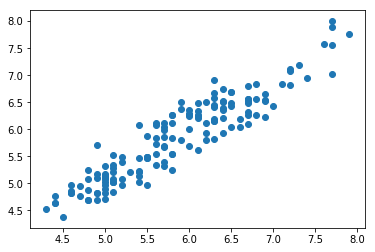

In [102]:
plt.scatter(iris['Sepal.Length'], np.fromstring(result[0], sep=','))
plt.show()

---
## Extensions

This notebook showcases a straightforward example to train and host an R algorithm in Amazon SageMaker.  As mentioned previously, this notebook could also be written in R.  We could even train the algorithm entirely within a notebook and then simply use the serving portion of the container to host our model.

Other extensions could include setting up the R algorithm to train in parallel.  Although R is not the easiest language to build distributed applications on top of, this is possible.  In addition, running multiple versions of training simultaneously would allow for parallelized grid (or random) search for optimal hyperparamter settings.  This would more fully realize the benefits of managed training.

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [103]:
## delete endpoint:
sm.delete_endpoint(EndpointName=r_endpoint)

{'ResponseMetadata': {'RequestId': 'cf44605b-c716-457b-8dfd-5ebdce961847',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'cf44605b-c716-457b-8dfd-5ebdce961847',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 05 Sep 2018 13:57:44 GMT'},
  'RetryAttempts': 0}}

### (Additional) (Optional) Clean-up

In [105]:
## delete endpoint configuration:
sm.delete_endpoint_config(EndpointConfigName = r_endpoint_config)

{'ResponseMetadata': {'RequestId': 'ffa7f8ec-d511-46f3-8144-3174ea35f166',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ffa7f8ec-d511-46f3-8144-3174ea35f166',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 05 Sep 2018 13:59:44 GMT'},
  'RetryAttempts': 0}}

In [106]:
## delete registered model:
sm.delete_model(ModelName = r_job)

{'ResponseMetadata': {'RequestId': 'be3bbc1b-5dc7-489c-b806-02d94f1a28f0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'be3bbc1b-5dc7-489c-b806-02d94f1a28f0',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 05 Sep 2018 14:01:49 GMT'},
  'RetryAttempts': 0}}